In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam
import gym

import sys
sys.path.append('module/')

from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
/Users/admin/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/admin/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/admin/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/admin/.pyenv/

In [2]:
# GymのPendulum環境を作成
env = gym.make("Pendulum-v0")

# 取りうる”打ち手”のアクション数と値の定義
nb_actions = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory
    )
    return agent







Training for 150000 steps ...
Interval 1 (0 steps performed)
 1848/10000 [====>.........................] - ETA: 36s - reward: -3.3443done, took 8.383 seconds


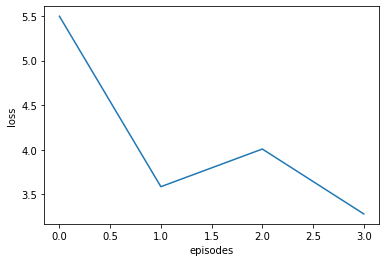

Finish Learning. We start test phase.
Testing for 5 episodes ...
Episode 1: reward: -405.113, steps: 200
Episode 2: reward: -527.785, steps: 200
Episode 3: reward: -501.054, steps: 200
Episode 4: reward: -897.180, steps: 200
Episode 5: reward: -518.832, steps: 200


In [5]:
#event-base learning with time-based initial agent
l = 2
a = agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mse"])
a.load_weights('./learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=150000, visualize=0, verbose=1, nb_max_episode_steps=200, loss_graph=1)
print('Finish Learning. We start test phase.')
a.test(env, lam=l, nb_episodes=5, visualize=True, nb_max_episode_steps=200)
a.save_weights(f'learned_models/good{l}.h5')

Testing for 5 episodes ...
Episode 1: reward: -1192.817, steps: 200


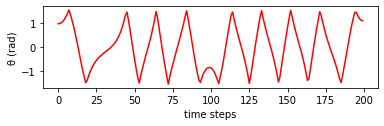

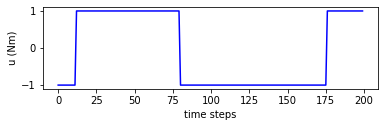

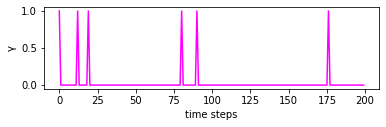

Episode 2: reward: -1277.149, steps: 200


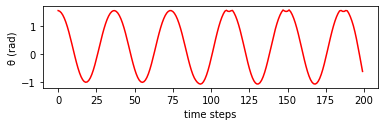

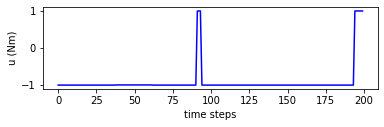

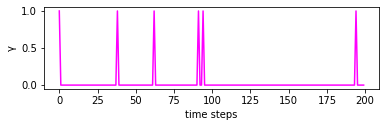

Episode 3: reward: -1267.529, steps: 200


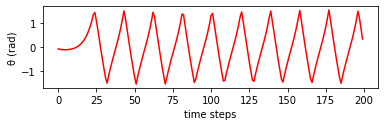

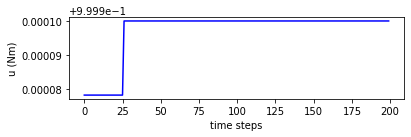

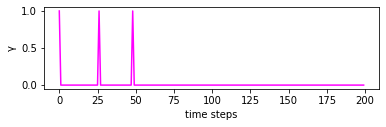

Episode 4: reward: -1280.942, steps: 200


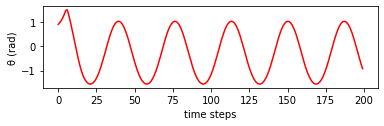

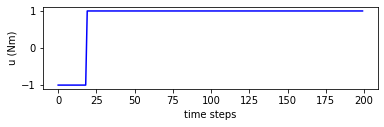

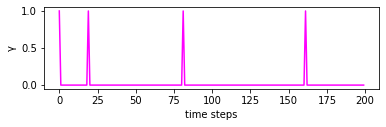

Episode 5: reward: -1184.906, steps: 200


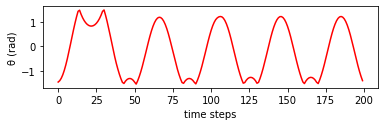

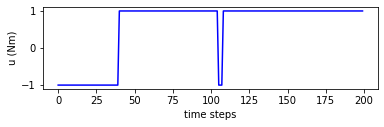

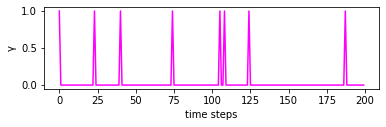

In [20]:
a.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200, graph=True,action_view=0)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 72s 7ms/step - reward: -4.5694
50 episodes - episode_reward: -913.877 [-1353.452, -669.386] - loss: 41.504 - mean_squared_error: 83.009 - mean_q: -80.491

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 82s 8ms/step - reward: -4.5921
50 episodes - episode_reward: -918.428 [-1420.222, -687.056] - loss: 36.165 - mean_squared_error: 72.330 - mean_q: -70.418

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 80s 8ms/step - reward: -4.1604
50 episodes - episode_reward: -832.087 [-1035.382, -678.397] - loss: 28.810 - mean_squared_error: 57.621 - mean_q: -52.304

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 78s 8ms/step - reward: -4.5598
50 episodes - episode_reward: -911.964 [-1732.902, -527.879] - loss: 23.645 - mean_squared_error: 47.291 - mean_q: -42.430

Interval 5 (40000 steps per

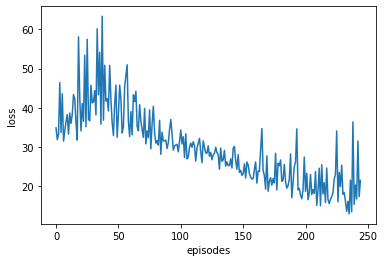

In [47]:
a.fit(env, lam=l, nb_steps=50000, visualize=0, verbose=1, nb_max_episode_steps=200, loss_graph=1)

Testing for 5 episodes ...
Episode 1: reward: -19.937, steps: 200


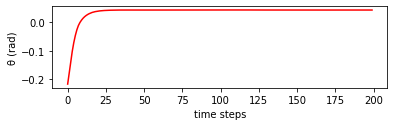

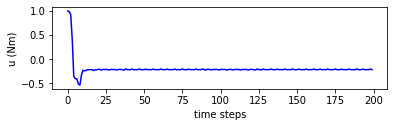

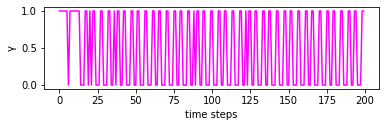

Episode 2: reward: -861.145, steps: 200


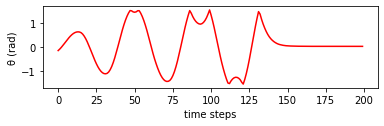

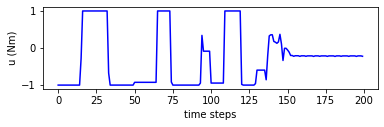

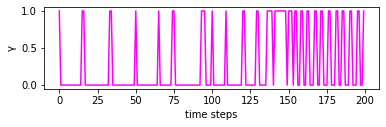

Episode 3: reward: -1154.588, steps: 200


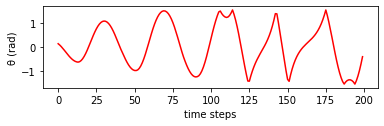

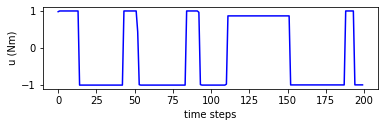

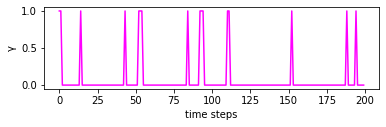

Episode 4: reward: -1118.710, steps: 200


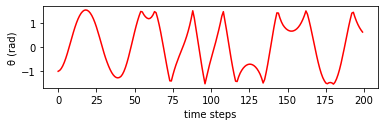

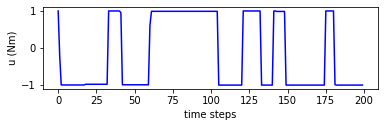

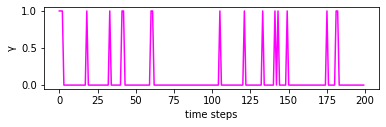

Episode 5: reward: -646.907, steps: 200


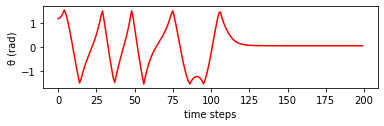

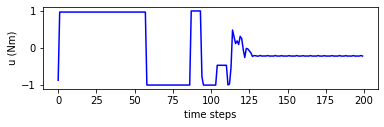

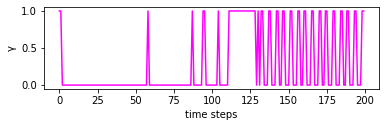

In [13]:
l = 0.8
a =  agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
#a.load_weights(f'./learned_models/good{l}.h5')
a.load_weights(f'./learned_models/normal{l}.h5')
a.test(env, lam=l, nb_episodes=5, visualize=True, nb_max_episode_steps=200, graph=1)

Testing for 1 episodes ...
step =  1 , output of actor network =  [ 0.9999989 -0.7795443 -0.9999991]
step =  2 , output of actor network =  [ 0.84119976 -0.9998244  -0.99999994]
step =  3 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  4 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  5 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  6 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  7 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  8 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  9 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  10 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  11 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  12 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step =  13 , output of actor network =  [-0.9999999 -0.9999993 -1.       ]
step

step =  116 , output of actor network =  [ 0.2217733  0.9999533 -0.999978 ]
step =  117 , output of actor network =  [ 0.23451369  0.99995244 -0.99997747]
step =  118 , output of actor network =  [ 0.23451369  0.99995244 -0.99997747]
step =  119 , output of actor network =  [ 0.23451369  0.99995244 -0.99997747]
step =  120 , output of actor network =  [ 0.22398253  0.9999531  -0.99997795]
step =  121 , output of actor network =  [ 0.22398253  0.9999531  -0.99997795]
step =  122 , output of actor network =  [ 0.22398253  0.9999531  -0.99997795]
step =  123 , output of actor network =  [ 0.22398253  0.9999531  -0.99997795]
step =  124 , output of actor network =  [ 0.22398253  0.9999531  -0.99997795]
step =  125 , output of actor network =  [ 0.23468438  0.99995244 -0.9999776 ]
step =  126 , output of actor network =  [ 0.23468438  0.99995244 -0.9999776 ]
step =  127 , output of actor network =  [ 0.23468438  0.99995244 -0.9999776 ]
step =  128 , output of actor network =  [ 0.22379406  

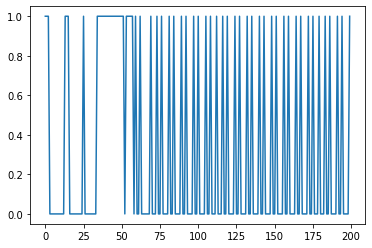

In [11]:
a.test(env, lam=l, nb_episodes=1, visualize=True, nb_max_episode_steps=200, graph=1, action_view=1)

W1009 18:32:28.364133 140735584400256 deprecation_wrapper.py:119] From /Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1009 18:32:28.388212 140735584400256 deprecation_wrapper.py:119] From /Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 18:32:28.407072 140735584400256 deprecation_wrapper.py:119] From /Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4158: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1009 18:32:28.529716 140735584400256 deprecation_wrapper.py:119] From /Users/admin/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is de

Testing for 5 episodes ...
Episode 1: reward: -0.404, steps: 200


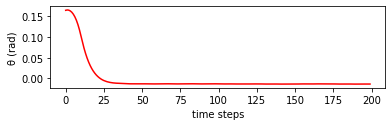

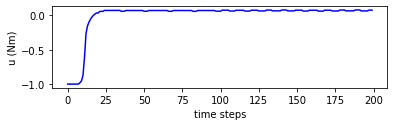

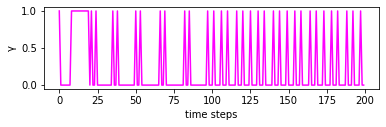

Episode 2: reward: -123.135, steps: 200


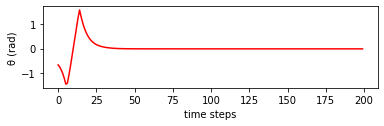

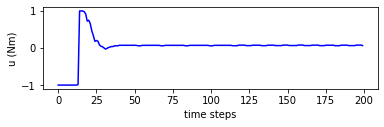

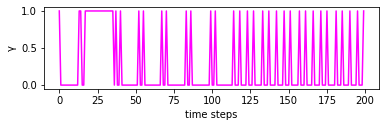

Episode 3: reward: -239.054, steps: 200


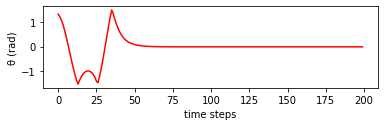

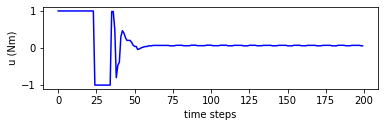

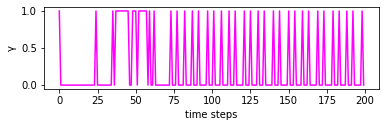

Episode 4: reward: -484.315, steps: 200


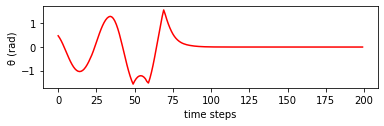

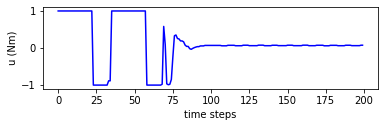

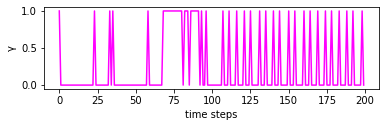

Episode 5: reward: -493.129, steps: 200


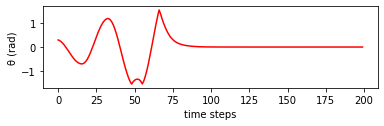

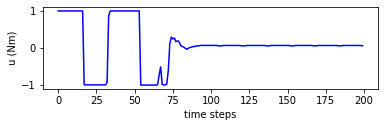

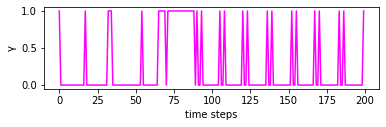

In [5]:
l = 0
a =  agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.load_weights('./learned_models/0.model.h5')
a.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200,graph=1)

Instructions for updating:
Colocations handled automatically by placer.
Testing for 5 episodes ...
Episode 1: reward: -585.136, steps: 200


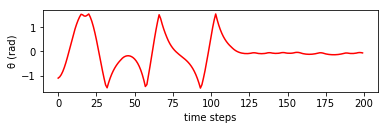

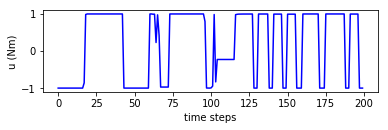

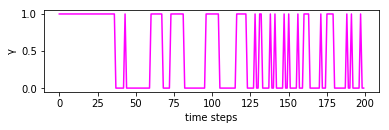

Episode 2: reward: -979.068, steps: 200


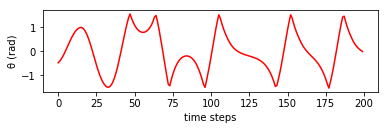

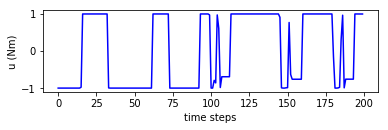

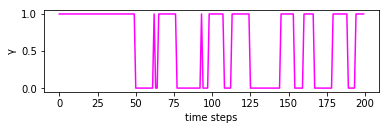

Episode 3: reward: -606.045, steps: 200


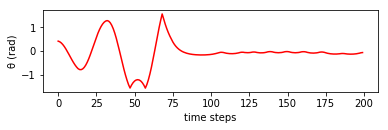

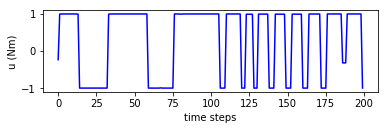

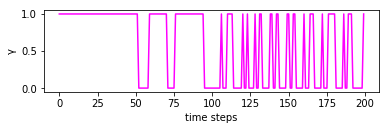

Episode 4: reward: -323.383, steps: 200


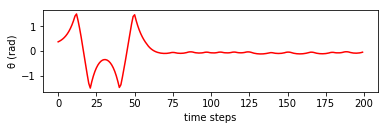

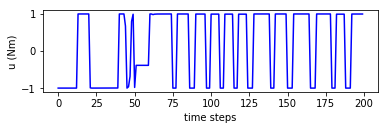

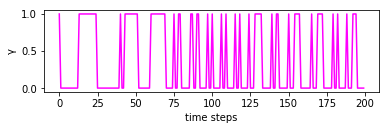

Episode 5: reward: -592.342, steps: 200


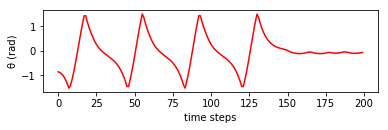

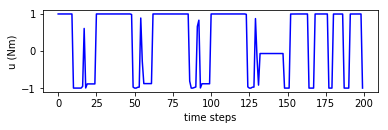

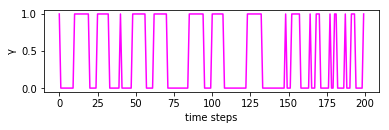

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

l = 1.
a =  agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mse"])
a.load_weights('./learned_models_vol2/1.0eventmodel.h5')
a.test(env, lam=l, nb_episodes=5, visualize=0, nb_max_episode_steps=200, graph=1)

In [13]:
a.save_weights('./learned_models_vol2/eventmodel2.h5')

In [4]:
from keras.utils.vis_utils import plot_model
plot_model(a)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(1, ) + (84,)))
model.add(Dense(128, kernel_initializer='he_normal', activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(128, kernel_initializer='he_normal', activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(128, kernel_initializer='he_normal', activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(3, activation='linear'))
print(model.summary())

memory = SequentialMemory(limit=200000, window_length=1)
policy = EpsGreedyQPolicy(eps = 0.1)
dqn = DQNAgent(model=model, nb_actions=3,gamma=0.99, memory=memory, nb_steps_warmup=100,target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
import tensorflow as tf

from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy
from rl.agents.dqn import DQNAgent

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(1, ) + (84,)))
model.add(tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(128, kernel_initializer='he_normal', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(3, activation='linear'))
print(model.summary())

memory = SequentialMemory(limit=200000, window_length=1)
policy = EpsGreedyQPolicy(eps = 0.1)
dqn = DQNAgent(model=model, nb_actions=3,gamma=0.99, memory=memory, nb_steps_warmup=100,target_model_update=1e-2, policy=policy)
dqn.compile(tf.keras.optimizers.Adam(lr=1e-3), metrics=['mae'])